In [0]:
from pathlib import Path
from joblib import load, dump
import matplotlib.pyplot as plt
import json
import numpy as np
import pandas as pd
from collections import Counter

In [0]:
from dataclasses import dataclass, asdict
from typing import Any, List
import joblib
import pathlib
import msgpack
import gzip


@dataclass
class Player:
    __slots__ = ['account_id',
                 'team',
                 'assists',
                 'deaths',
                 'gold_per_min',
                 'hero_id',
                 'kills',
                 'level',
                 'xp_per_min']

    account_id: Any
    team: Any
    assists: Any
    deaths: Any
    gold_per_min: Any
    hero_id: Any
    kills: Any
    level: Any
    xp_per_min: Any


@dataclass
class PickBan:
    __slots__ = ['hero_id',
                 'is_pick',
                 'order',
                 'team']

    hero_id: Any
    is_pick: Any
    order: Any
    team: Any


@dataclass
class Game:
    __slots__ = ['cluster',
                 'dire_score',
                 'duration',
                 'first_blood_time',
                 'game_mode',
                 'human_players',
                 'lobby_type',
                 'match_id',
                 'match_seq_num',
                 'negative_votes',
                 'picks_bans',
                 'players',
                 'positive_votes',
                 'radiant_score',
                 'radiant_win',
                 'start_time']

    cluster: Any
    dire_score: Any
    duration: Any
    first_blood_time: Any
    game_mode: Any
    human_players: Any
    lobby_type: Any
    match_id: Any
    match_seq_num: Any
    negative_votes: Any
    picks_bans: Any
    players: Any
    positive_votes: Any
    radiant_score: Any
    radiant_win: Any
    start_time: Any

    def __post_init__(self):
        picks_bans = self.picks_bans
        players = self.players

        pb_list = []
        if picks_bans is not None:
            for pb in picks_bans:
                pb_clear = subset_of_dict(pb, PickBan.__slots__)
                pb_list.append(PickBan(**pb_clear))
        pb_list.sort(key=lambda x_pb: x_pb.order)
        self.picks_bans = pb_list

        pl_list = []
        for pl in players:
            if 'team' not in pl.keys():
                pl['team'] = 1 if pl['player_slot'] < 128 else 0
            pl_clear = subset_of_dict(pl, Player.__slots__)
            pl_list.append(Player(**pl_clear))
        self.players = pl_list


def subset_of_dict(dictionary: dict, keys: List[str]) -> dict:
    return {key: dictionary[key] for key in keys if key in dictionary}


def load_games(path: str) -> List[Game]:
    return joblib.load(path)


def dump_games(games: List[Game], path: str) -> None:
    joblib.dump(games, path)


def game_to_dict(game: Game) -> dict:
    return asdict(game)


def dict_to_game(dictionary: dict) -> Game:
    try:
        dictionary_clear = subset_of_dict(dictionary, Game.__slots__)
        new_game = Game(**dictionary_clear)
        return new_game
    except Exception as ex:
        print(dictionary)
        raise ex


def save_to_msgpack(games_list: List[Game], path: str) -> None:
    if not pathlib.Path(path).suffixes:
        path = path + '.msgpack.gz'

    def encode_game(obj):
        if isinstance(obj, Game):
            return {'__game': True, '__data': game_to_dict(obj)}
        return obj

    with gzip.open(path, 'wb') as gz_file:
        msgpack.dump(games_list, gz_file, default=encode_game)


def load_from_msgpack(path: str) -> List[Game]:
    if not pathlib.Path(path).suffixes:
        path = path + '.msgpack.gz'

    def decode_game(obj):
        if '__game' in obj:
            obj = dict_to_game(obj['__data'])
        return obj

    with gzip.open(path, 'rb') as gz_file:
        result = msgpack.load(gz_file, object_hook=decode_game)

    return result

# Start

In [0]:
dataset = load_from_msgpack('/content/drive/My Drive/presonalizacja/new_scap/scrap_merge_full')

In [0]:
print(f"Number of games: {len(dataset)}")

Number of games: 1899625


In [0]:
unique_seq = []
unique_hero = set()
for game in dataset:
  seq = (p.hero_id for p in game.players)
  unique_seq.append(seq)
  unique_hero.update(seq)
len(set(unique_seq))

1899625

In [0]:
with open('/content/drive/My Drive/presonalizacja/heroes.json', 'rt') as f:
    hero_dict = json.load(f)

def get_hero_name(id, hero_dict):
    return hero_dict[str(int(id))]['localized_name']

Stastystki pick/ban dla bohaterów

In [0]:
def get_stats(picks, bans, hero_dict):
    df_picks = pd.DataFrame(np.vstack(np.unique(picks, return_counts=True)).T, columns=['id', 'picks'])
    df_bans = pd.DataFrame(np.vstack(np.unique(bans, return_counts=True)).T, columns=['id', 'bans'])
    df = df_picks.merge(df_bans, on='id')
    df['pb'] = df.apply(lambda row: row.picks/(row.picks+row.bans), axis=1)
    df['name'] = df.apply(lambda row: get_hero_name(row.id, hero_dict), axis=1)
    return df[['name','picks', 'bans', 'pb']]

In [0]:
picks = []
bans = []
for data in dataset:
  if data.picks_bans is not None:
    for pick in data.picks_bans:
      if pick.hero_id is not None:
        if pick.is_pick:
          picks.append(pick.hero_id)
        else:
          bans.append(pick.hero_id)

19054663


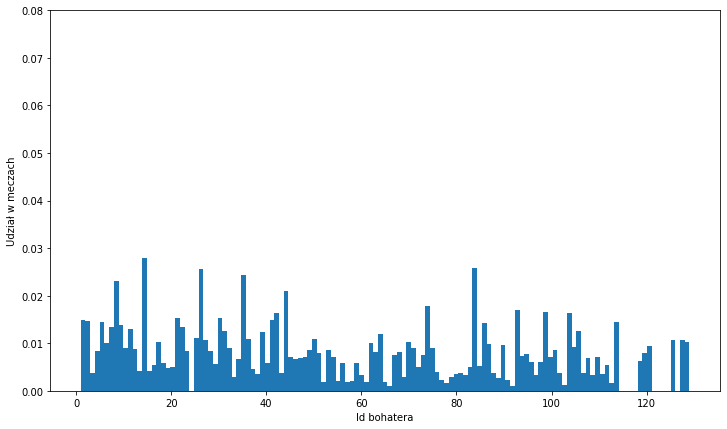

,name,picks,bans,pb
13,Pudge,527285,206333,0.718746
82,Ogre Magi,487167,51160,0.904965
24,Lion,484198,80823,0.856956
33,Sniper,458524,292298,0.610696
7,Juggernaut,437843,117567,0.788324
42,Phantom Assassin,396735,307466,0.563383
72,Invoker,335858,207431,0.618194
91,Slark,323027,293057,0.524323
97,Bristleback,313635,177197,0.638986
40,Wraith King,310761,75125,0.805318


In [0]:
plt.figure(figsize=(12,7))
plt.hist(picks, bins=129, density=True)
plt.ylim([0, 0.08])
plt.xlabel('Id bohatera')
plt.ylabel('Udział w meczach')
plt.savefig('/content/drive/My Drive/presonalizacja/plots/picks.png')
print(len(picks))
plt.show()
get_stats(picks, bans, hero_dict).sort_values('picks', ascending=False).head(15)

8581753


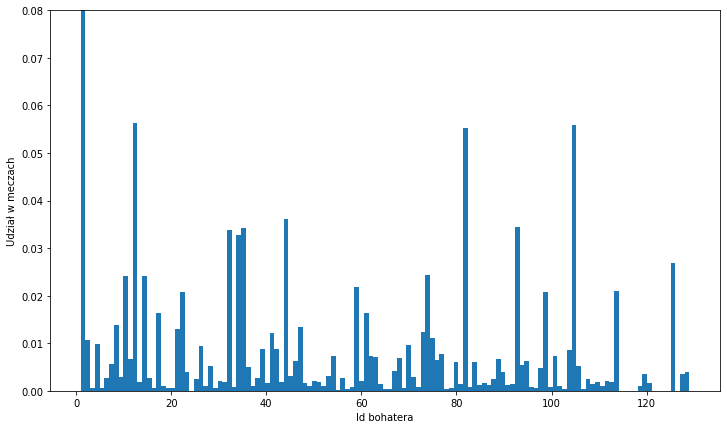

,name,picks,bans,pb
0,Anti-Mage,279572,687079,0.289217
11,Phantom Lancer,165064,479506,0.256084
103,Techies,173222,476677,0.266537
80,Meepo,62219,470184,0.116864
42,Phantom Assassin,396735,307466,0.563383
91,Slark,323027,293057,0.524323
33,Sniper,458524,292298,0.610696
30,Riki,171329,287152,0.373688
32,Tinker,125323,279181,0.309819
116,Void Spirit,201606,228195,0.469068


In [0]:
plt.figure(figsize=(12,7))
plt.hist(bans, bins=119, density=True)
plt.xlabel('Id bohatera')
plt.ylabel('Udział w meczach')
plt.savefig('/content/drive/My Drive/presonalizacja/plots/bans.png')
plt.ylim([0, 0.08])
print(len(bans))
plt.show()
get_stats(picks, bans, hero_dict).sort_values('bans', ascending=False).head(15)

In [0]:
get_stats(picks, bans, hero_dict).sort_values('pb', ascending=False).head(15)

,name,picks,bans,pb
4,Crystal Maiden,275160,5260,0.981242
25,Shadow Shaman,201806,7743,0.963049
15,Sand King,101291,4742,0.955278
27,Tidehunter,107701,5249,0.953528
47,Dragon Knight,160569,8111,0.951915
84,Rubick,269400,14553,0.948749
98,Tusk,132857,7290,0.947983
62,Jakiro,227550,12674,0.947241
105,Earth Spirit,69931,4035,0.945448
53,Dark Seer,39074,2255,0.945438


In [0]:
get_stats(picks, bans, hero_dict).sort_values('pb', ascending=False).tail(15)

,name,picks,bans,pb
42,Phantom Assassin,396735,307466,0.563383
45,Viper,130301,114723,0.531789
91,Slark,323027,293057,0.524323
87,Naga Siren,50996,57469,0.470161
116,Void Spirit,201606,228195,0.469068
9,Morphling,171298,205798,0.454256
75,Lycan,43120,65699,0.396254
30,Riki,171329,287152,0.373688
57,Huskar,110193,186643,0.371225
32,Tinker,125323,279181,0.309819


Win ratio per hero

In [0]:
win = []
all_games = []
for game in dataset:
  dire_heroes = [ p.hero_id for p in game.players if p.team == 0]
  radiant_heroes = [ p.hero_id for p in game.players if p.team == 1]
  all_games.extend(dire_heroes)
  all_games.extend(radiant_heroes)
  if game.radiant_win:
    win.extend(radiant_heroes)
  else:
    win.extend(dire_heroes)

In [0]:
ag = Counter(all_games)
w = Counter(win)

In [0]:
win_ratio = dict()
for i in range(len(ag)):
  if ag[i] >0:
    win_ratio[i] = w[i] /ag[i]
  else:
    win_ratio[i] = 0

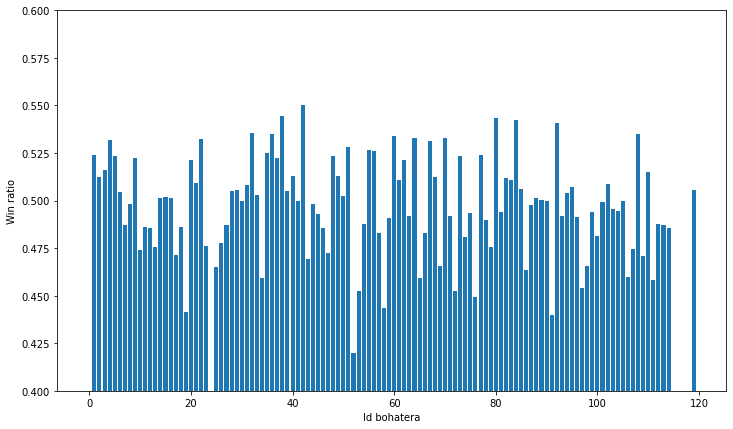

In [0]:
plt.figure(figsize=(12,7))
D = win_ratio
plt.bar(range(len(D)), list(D.values()), align='center')
plt.ylim([0.4,0.6])
plt.xlabel('Id bohatera')
plt.ylabel('Win ratio')
plt.savefig('/content/drive/My Drive/presonalizacja/plots/win_ratio.png')
plt.show()

In [0]:
d = []
a = []
k = []
gpm = []
xpm = []
for data in dataset:
    for player in data.players:
      d.append(player.deaths)
      a.append(player.assists)
      k.append(player.kills)
      gpm.append(player.gold_per_min)
      xpm.append(player.xp_per_min)

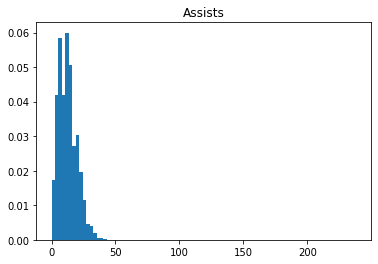

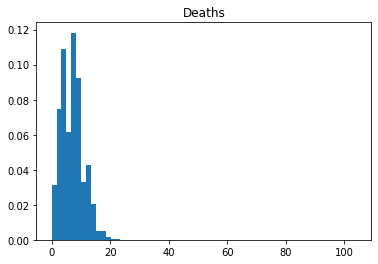

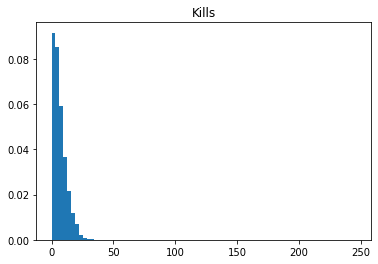

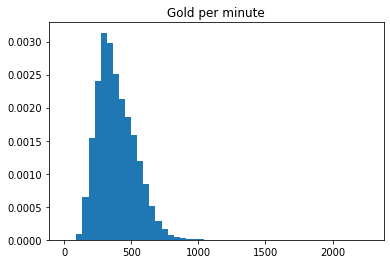

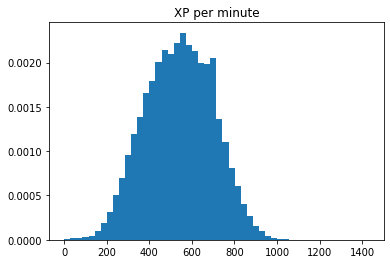

In [0]:
plt.hist(a, bins = len(np.unique(a)), density = True)
plt.title('Assists')
plt.show()
plt.hist(d, bins = len(np.unique(d)), density = True)
plt.title('Deaths')
plt.show()
plt.hist(k, bins = len(np.unique(k)), density = True)
plt.title('Kills')
plt.show()
plt.hist(gpm, bins = 50, density = True)
plt.title('Gold per minute')
plt.show()
plt.hist(xpm, bins = 50, density = True)
plt.title('XP per minute')
plt.show()

In [0]:
radiant_win = 0
for data in dataset:
    radiant_win += 1 if data.radiant_win else 0
print(f"Radiant win: {radiant_win/len(dataset)}%")

Radiant win: 0.5340480357965388%


Max time:  102


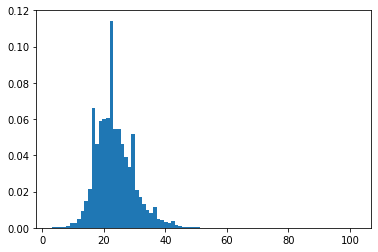

In [0]:
times = []
for data in dataset:
    times.append(data.duration//100)
plt.hist(times, bins = len(np.unique(times)), density = True)
plt.plot()
print('Max time: ',max(times))